# ADS 509 Text Mining Project

**Lorena Dorado & Parisa Kamizi** 

## Load and Explore the Dataset Structure

In [3]:
#!pip install textacy
#!pip install textblob
#!pip install langdetect

In [4]:
# Standard Libraries
import os
import re
import glob
import json
import pickle
import logging
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter, defaultdict

# Progress Monitoring
from tqdm import tqdm
tqdm.pandas()

# Text Processing & NLP
import html
import textacy
import textacy.preprocessing as tprep
from textblob import TextBlob
from langdetect import detect
import nltk
import spacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
from spacy.lang.en.stop_words import STOP_WORDS

# NLTK Resources
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))


# Feature Engineering & Vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Machine Learning & Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.sparse import hstack
from sklearn.decomposition import NMF, TruncatedSVD  # Add TruncatedSVD for LSA

# Dimensionality Reduction & Topic Modeling
from sklearn.decomposition import (
    LatentDirichletAllocation, 
    NMF, 
    TruncatedSVD
)
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.manifold import TSNE  # For high-dimensional visualization

# Stopwords & Punctuation 
from string import punctuation


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/parisakamizi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!




For this project, we first set up logging to track progress and errors, saving logs to a file and displaying them in the console. We then load our DeepSeek CSV files, reading news data into a combined dataframe. The date column is converted into a proper datetime format, and text fields are cleaned by filling missing values and removing extra spaces. If no files are found or an error occurs while reading a file, the issue is logged. Finally, we log the total number of rows loaded and return the cleaned dataframe.







In [6]:
# Setup logging
def setup_logging():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler('text_mining.log'),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

logger = setup_logging()
logger.info("Setup complete")

# Part 2: Data Loading
def load_news_data(directory='.'):
    """
    Load and combine multiple CSV files containing news data from a directory.
    """
    column_mapping = {
        'source_name': 'source',
        'publishedAt': 'date',
        'content': 'text',
        'title': 'title',
        'description': 'description'
    }
    
    csv_files = glob.glob(os.path.join(directory, '*.csv'))
    dfs = []
    
    for file in csv_files:
        try:
            temp_df = pd.read_csv(file)
            dfs.append(temp_df)
            logger.info(f"Successfully loaded {file}")
        except Exception as e:
            logger.error(f"Error reading file {file}: {str(e)}")
    
    if not dfs:
        raise ValueError("No CSV files were successfully loaded")
    
    combined_df = pd.concat(dfs, ignore_index=True)
    final_df = combined_df[column_mapping.keys()].rename(columns=column_mapping)
    
    # Convert date column to datetime
    final_df['date'] = pd.to_datetime(final_df['date'])
    
    # Basic cleaning
    for text_col in ['text', 'title', 'description']:
        final_df[text_col] = final_df[text_col].fillna('').str.strip()
    
    logger.info(f"Loaded {len(final_df)} rows from {len(csv_files)} files")
    return final_df

2025-02-16 01:22:49,410 - INFO - Setup complete


In [7]:
# Load the data
news_df = load_news_data()
print("\nDataset Info:")
print(news_df.info())
print("\nFirst few rows:")
print(news_df.head())

2025-02-16 01:22:49,433 - INFO - Successfully loaded ./Deepseek_Day_Four.csv
2025-02-16 01:22:49,443 - INFO - Successfully loaded ./deepseek_cleaned.csv
2025-02-16 01:22:49,448 - INFO - Successfully loaded ./Deepseek_Day_One.csv
2025-02-16 01:22:49,452 - INFO - Successfully loaded ./deepseek_20250214.csv
2025-02-16 01:22:49,455 - INFO - Successfully loaded ./Deepseek_Day_Three.csv
2025-02-16 01:22:49,457 - INFO - Successfully loaded ./deepseek_eda.csv
2025-02-16 01:22:49,460 - INFO - Successfully loaded ./Deepseek_Day_Five.csv
2025-02-16 01:22:49,464 - INFO - Successfully loaded ./Deepseek_Day_Two.csv
2025-02-16 01:22:49,476 - INFO - Successfully loaded ./deepseek_all.csv
2025-02-16 01:22:49,488 - INFO - Loaded 3250 rows from 9 files



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3250 entries, 0 to 3249
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   source       1261 non-null   object             
 1   date         1261 non-null   datetime64[ns, UTC]
 2   text         3250 non-null   object             
 3   title        3250 non-null   object             
 4   description  3250 non-null   object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 127.1+ KB
None

First few rows:
             source                      date  \
0  Business Insider 2025-02-03 12:23:17+00:00   
1          Hackaday 2025-02-04 00:00:00+00:00   
2       Gizmodo.com 2025-02-03 20:45:34+00:00   
3        Xataka.com 2025-02-03 13:30:24+00:00   
4    The New Yorker 2025-02-03 11:00:00+00:00   

                                                text  \
0  Jakub Porzycki/NurPhoto via Getty Images\r\n<u...   
1  The

## Text Cleaning and Preprocessing

In this section, we are performing text cleaning, language detection, and duplicate removal. First, we handle missing values, then convert HTML escapes, remove URLs, fix encoding issues, and eliminate unnecessary special characters and whitespace. Finally, duplicate articles are removed by creating a unique signature based on the title and the first 200 characters of the text, ensuring only distinct articles remain in the dataset.









In [10]:
def clean_news_text(text):
    """Enhanced text cleaning function"""
    if not text or pd.isna(text):
        return ""
    
    # convert html escapes
    text = html.unescape(text)
    
    # Remove "[+XXX chars]" pattern
    text = re.sub(r'\[\+\d+ chars\]', '', text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)
    
    # Clean special characters and encoding issues
    text = re.sub(r'â€™', "'", text)
    text = re.sub(r'â€"', "-", text)
    text = re.sub(r'[^\w\s\-\'.,!?]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

def detect_and_handle_language(text):
    """Detect language of text"""
    try:
        return detect(text)
    except:
        return 'unknown'

def remove_duplicates(df):
    """Remove duplicate articles based on content similarity"""
    df['text_signature'] = df['title'] + df['text'].str[:200]
    original_len = len(df)
    df = df.drop_duplicates(subset=['text_signature'])
    df = df.drop('text_signature', axis=1)
    logger.info(f"Removed {original_len - len(df)} duplicate articles")
    return df

We perform more thorough cleaning here by removing unwanted characters, fixing encoding issues, and standardizing the text. Next, we identify the language of each cleaned text to understand the dataset's linguistic composition. After that, we remove duplicate articles by comparing content similarity, resulting in a final dataset of 572 entries. The cleaned dataset retains key columns such as source, date, text, title, description, clean text, and detected language. The language distribution shows that English is the most common (304 entries), followed by Dutch (86), Spanish (67), German (27), and several other languages. Additionally, two entries could not be identified and are labeled as "unknown." Finally, we print the dataset details after cleaning to ensure data integrity.
















In [12]:
# Apply text cleaning
news_df['clean_text'] = news_df['text'].progress_apply(clean_news_text)
news_df['language'] = news_df['clean_text'].progress_apply(detect_and_handle_language)
news_df = remove_duplicates(news_df)

print("\nCleaned Dataset Info:")
print(news_df.info())
print("\nLanguage distribution:")
print(news_df['language'].value_counts())

100%|██████████████████████████████████████| 3250/3250 [00:08<00:00, 403.22it/s]
2025-02-16 01:22:57,712 - INFO - Removed 2678 duplicate articles



Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 572 entries, 0 to 1729
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   source       571 non-null    object             
 1   date         571 non-null    datetime64[ns, UTC]
 2   text         572 non-null    object             
 3   title        572 non-null    object             
 4   description  572 non-null    object             
 5   clean_text   572 non-null    object             
 6   language     572 non-null    object             
dtypes: datetime64[ns, UTC](1), object(6)
memory usage: 35.8+ KB
None

Language distribution:
en         303
nl          86
es          67
de          27
fr          19
pt          18
it          17
vi           7
id           4
et           4
hu           4
tr           4
pl           3
unknown      2
so           1
sk           1
lt           1
cs           1
ro           1
no     

In this section, We defines a text preprocessing pipeline that cleans textual data by removing punctuation, tokenizing words, and filtering out stopwords. 







In [14]:

# Define the punctuation set
punctuation_set = set(punctuation)

# Function to remove punctuation
def remove_punctuation(text, punct_set=punctuation_set):
    return "".join([ch for ch in text if ch not in punct_set])

# Load stopwords
sw = stopwords.words("english")

# Function to remove stopwords
def remove_stop(tokens):
    return [word for word in tokens if word not in sw]

# Function to tokenize the text
def tokenize(text):
    return text.split()

def pipeline(text):
    text = str.lower(text)  # Convert to lowercase
    text = remove_punctuation(text)  # Remove punctuation
    tokens = tokenize(text)  # Tokenize the text
    tokens = remove_stop(tokens)  # Remove stopwords
    return ' '.join(tokens)  # Return the cleaned text as a string

news_df['cleaned_content'] = news_df['text'].apply(pipeline)

print(news_df[['text', 'cleaned_content']].head())


                                                text  \
0  Jakub Porzycki/NurPhoto via Getty Images\r\n<u...   
1  The DeepSeek large language models (LLM) have ...   
2  In what could be SoftBank’s newest trick to ma...   
3  El hardware utilizado por DeepSeek para entren...   
4  Last week, shortly before the start of the Chi...   

                                     cleaned_content  
0  jakub porzyckinurphoto via getty images ullith...  
1  deepseek large language models llm making head...  
2  could softbank’s newest trick make ungodly amo...  
3  el hardware utilizado por deepseek para entren...  
4  last week shortly start chinese new year much ...  


We perform text preprocessing by converting the text column to a string, applying a cleaning pipeline to generate Cleaned_Text, tokenizing it into Tokens.








In [16]:
# Converts 'text' column to string (if not already)
news_df['text'] = news_df['text'].astype(str)

# Cleans 'text' using the pipeline
news_df['Cleaned_Text'] = news_df['text'].apply(pipeline)

# Tokenizes the 'Cleaned_Text'
news_df['Tokens'] = news_df['Cleaned_Text'].apply(tokenize)

# Display the results
print(news_df[['text', 'Cleaned_Text', 'Tokens']].head())

news_df.head()

                                                text  \
0  Jakub Porzycki/NurPhoto via Getty Images\r\n<u...   
1  The DeepSeek large language models (LLM) have ...   
2  In what could be SoftBank’s newest trick to ma...   
3  El hardware utilizado por DeepSeek para entren...   
4  Last week, shortly before the start of the Chi...   

                                        Cleaned_Text  \
0  jakub porzyckinurphoto via getty images ullith...   
1  deepseek large language models llm making head...   
2  could softbank’s newest trick make ungodly amo...   
3  el hardware utilizado por deepseek para entren...   
4  last week shortly start chinese new year much ...   

                                              Tokens  
0  [jakub, porzyckinurphoto, via, getty, images, ...  
1  [deepseek, large, language, models, llm, makin...  
2  [could, softbank’s, newest, trick, make, ungod...  
3  [el, hardware, utilizado, por, deepseek, para,...  
4  [last, week, shortly, start, chinese, new, yea..

,source,date,text,title,description,clean_text,language,cleaned_content,Cleaned_Text,Tokens
0,Business Insider,2025-02-03 12:23:17+00:00,Jakub Porzycki/NurPhoto via Getty Images\r\n<u...,What investors can learn from the DeepSeek tec...,The DeepSeek saga offers investors valuable le...,Jakub Porzycki NurPhoto via Getty Images ul li...,en,jakub porzyckinurphoto via getty images ullith...,jakub porzyckinurphoto via getty images ullith...,"[jakub, porzyckinurphoto, via, getty, images, ..."
1,Hackaday,2025-02-04 00:00:00+00:00,The DeepSeek large language models (LLM) have ...,More Details On Why DeepSeek is a Big Deal,The DeepSeek large language models (LLM) have ...,The DeepSeek large language models LLM have be...,en,deepseek large language models llm making head...,deepseek large language models llm making head...,"[deepseek, large, language, models, llm, makin..."
2,Gizmodo.com,2025-02-03 20:45:34+00:00,In what could be SoftBank’s newest trick to ma...,SoftBank Is Betting Billions That OpenAI’s Age...,It's another big swing from an investment firm...,In what could be SoftBank s newest trick to ma...,en,could softbank’s newest trick make ungodly amo...,could softbank’s newest trick make ungodly amo...,"[could, softbank’s, newest, trick, make, ungod..."
3,Xataka.com,2025-02-03 13:30:24+00:00,El hardware utilizado por DeepSeek para entren...,Este es uno de los secretos del éxito de DeepS...,El hardware utilizado por DeepSeek para entren...,El hardware utilizado por DeepSeek para entren...,es,el hardware utilizado por deepseek para entren...,el hardware utilizado por deepseek para entren...,"[el, hardware, utilizado, por, deepseek, para,..."
4,The New Yorker,2025-02-03 11:00:00+00:00,"Last week, shortly before the start of the Chi...",Is DeepSeek China’s Sputnik Moment?,"The Chinese company’s low-cost, high-performan...","Last week, shortly before the start of the Chi...",en,last week shortly start chinese new year much ...,last week shortly start chinese new year much ...,"[last, week, shortly, start, chinese, new, yea..."


## EDA

In this section, we calculate descriptive statistics for text, including total word count, unique word count, character count, and lexical diversity. The function is then applied to each row, ensuring proper handling of empty text entries to prevent division by zero errors.









In [19]:
news_df['Tokens'] = news_df['cleaned_content'].apply(tokenize)


In [20]:
def descriptive_stats(tokens, title, num_tokens=5, verbose=True):
    if len(tokens) == 0:  # Prevent division by zero
        return [0, 0, 0, 0]  
    
    if verbose:
        print(f"Descriptive statistics for '{title}':")
        print(f"There are {len(tokens)} tokens in the text.")
        print(f"There are {len(set(tokens))} unique tokens in the text.")
        print(f"There are {len(''.join(tokens))} characters in the text.")
        print(f"The lexical diversity is {len(set(tokens)) / len(tokens):.3f} in the text.")

    counts = Counter(tokens)
    if num_tokens > 0:
        print(counts.most_common(num_tokens))
    print('\n')  

    return [len(tokens), len(set(tokens)), len(''.join(tokens)), len(set(tokens)) / len(tokens)]

news_df['Descriptive_Stats'] = news_df['Tokens'].apply(lambda tokens: descriptive_stats(tokens, "News Article", num_tokens=5))


Descriptive statistics for 'News Article':
There are 21 tokens in the text.
There are 20 unique tokens in the text.
There are 154 characters in the text.
The lexical diversity is 0.952 in the text.
[('business', 2), ('jakub', 1), ('porzyckinurphoto', 1), ('via', 1), ('getty', 1)]


Descriptive statistics for 'News Article':
There are 21 tokens in the text.
There are 21 unique tokens in the text.
There are 126 characters in the text.
The lexical diversity is 1.000 in the text.
[('deepseek', 1), ('large', 1), ('language', 1), ('models', 1), ('llm', 1)]


Descriptive statistics for 'News Article':
There are 24 tokens in the text.
There are 24 unique tokens in the text.
There are 140 characters in the text.
The lexical diversity is 1.000 in the text.
[('could', 1), ('softbank’s', 1), ('newest', 1), ('trick', 1), ('make', 1)]


Descriptive statistics for 'News Article':
There are 31 tokens in the text.
There are 30 unique tokens in the text.
There are 176 characters in the text.
The lexical

## Feature Engineering

In this section, we apply feature engineering by extracting sentiment scores, vectorizing text, and identifying key topics. We first analyze sentiment by computing polarity and subjectivity scores, providing insights into the emotional tone and objectivity of each article. The sentiment statistics reveal that most articles are neutral, with an average sentiment score of 0.01 and a subjectivity score of 0.29, indicating that articles tend to be more factual than opinion-based. While some articles show strong negative or positive sentiment, the majority cluster around neutrality. Next, we transform the text into a numerical format for further analysis. Finally, we apply topic modeling using Latent Dirichlet Allocation (LDA) to uncover common themes in the dataset, revealing that the articles primarily discuss AI-related topics, particularly DeepSeek and OpenAI, with content in multiple languages, such as Spanish and German.




In [23]:
def add_sentiment_features(df):
    """Add sentiment analysis features"""
    df['sentiment'] = df['text'].progress_apply(lambda x: TextBlob(x).sentiment.polarity)
    df['subjectivity'] = df['text'].progress_apply(lambda x: TextBlob(x).sentiment.subjectivity)
    return df

def create_news_vectorizer(min_df=2, max_df=0.95):
    """Create optimized vectorizer for news articles"""
    return CountVectorizer(
        stop_words='english',
        min_df=min_df, 
        max_df=max_df,
        ngram_range=(1, 2),
        token_pattern=r'\b\w+\b',
        strip_accents='unicode'
    )

def extract_topics(doc_term_matrix, n_topics=5, vectorizer=None):
    """Extract topics using LDA"""
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=20
    )
    topic_matrix = lda.fit_transform(doc_term_matrix)
    
    if vectorizer:
        feature_names = vectorizer.get_feature_names_out()
        topic_words = []
        for topic_idx, topic in enumerate(lda.components_):
            top_words = [feature_names[i] for i in topic.argsort()[:-10:-1]]
            topic_words.append(top_words)
        return topic_matrix, topic_words
    
    return topic_matrix

In [24]:
# Apply feature engineering
news_df = add_sentiment_features(news_df)
vectorizer = create_news_vectorizer()
doc_term_matrix = vectorizer.fit_transform(news_df['clean_text'])
topic_matrix, topic_words = extract_topics(doc_term_matrix, vectorizer=vectorizer)

print("\nTopic Words:")
for idx, words in enumerate(topic_words):
    print(f"\nTopic {idx + 1}: {', '.join(words)}")

print("\nSentiment Statistics:")
print(news_df[['sentiment', 'subjectivity']].describe())

100%|███████████████████████████████████████| 572/572 [00:00<00:00, 3437.09it/s]



Topic Words:

Topic 1: la, que, en, deepseek, el, y, ia, artificial, inteligencia

Topic 2: ai, s, deepseek, 2025, chinese, 01, 02, id, 2025 02

Topic 3: die, der, ki, deepseek, das, news, page, und, les

Topic 4: deepseek, ai, li, deepseek deepseek, r1, openai, li li, deepseek r1, chatgpt

Topic 5: deepseek, openai, ai, e, r1, di, altman, sam, deepseek r1

Sentiment Statistics:
        sentiment  subjectivity
count  572.000000    572.000000
mean     0.011193      0.295163
std      0.238247      0.322835
min     -0.900000      0.000000
25%      0.000000      0.000000
50%      0.000000      0.250000
75%      0.069886      0.494792
max      1.000000      1.000000


In [25]:
# Remove rows with empty/NaN sources
news_df = news_df.dropna(subset=['source'])

# Double check there are no more NaN sources
print("Number of NaN sources after cleaning:", news_df['source'].isna().sum())

Number of NaN sources after cleaning: 0


## Topic Modeling


In this section, we first create a dictionary and corpus from the tokenized text data. Then, we calculate coherence scores for different numbers of topics (ranging from 5 to 15) by running multiple LDA models and evaluating their coherence, which measures how well the topics are semantically meaningful. We select the optimal number of topics based on the highest coherence score. The most optimum # is 10 Topics.

2025-02-16 01:23:00,276 - INFO - adding document #0 to Dictionary(0 unique tokens: [])
2025-02-16 01:23:00,277 - INFO - built Dictionary(37 unique tokens: ['ai', 'deepseek', 'meta', 'trump', 'app']...) from 10 documents (total 43 corpus positions)
2025-02-16 01:23:00,277 - INFO - Dictionary lifecycle event {'msg': "built Dictionary(37 unique tokens: ['ai', 'deepseek', 'meta', 'trump', 'app']...) from 10 documents (total 43 corpus positions)", 'datetime': '2025-02-16T01:23:00.277908', 'gensim': '4.1.2', 'python': '3.9.19 (main, Mar 21 2024, 12:08:14) \n[Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2025-02-16 01:23:00,278 - INFO - using symmetric alpha at 0.2
2025-02-16 01:23:00,279 - INFO - using symmetric eta at 0.2
2025-02-16 01:23:00,281 - INFO - using serial LDA version on this node
2025-02-16 01:23:00,282 - INFO - running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 10 documents, updating model once every 10 

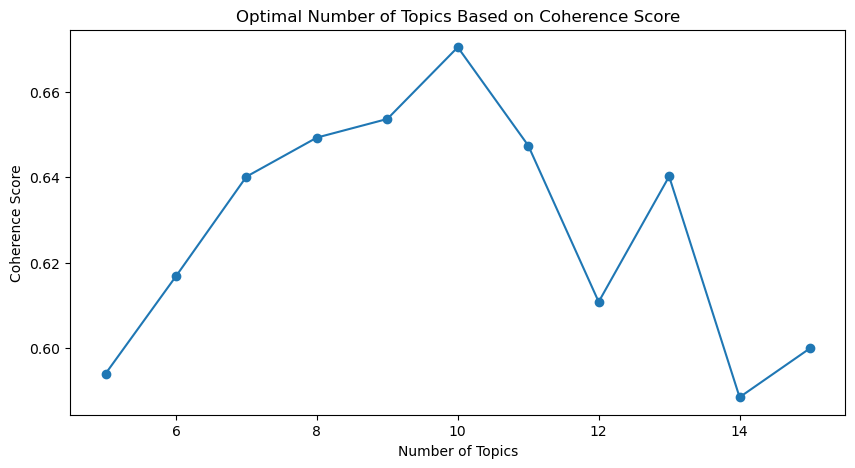

In [28]:

# Sample tokenized documents 
documents = [
    ["deepseek", "ai", "meta", "trump"],
    ["nvidia", "app", "chatgpt", "market"],
    ["deepseek", "die", "la", "di", "del"],
    ["r1", "deepseek", "open", "source"],
    ["2025", "id", "02", "10"],
    ["li", "s", "ul", "images", "getty"],
    ["ai", "deepseek", "chinese", "tech"],
    ["la", "que", "en", "el", "y"],
    ["openai", "o3", "deepseek", "mini"],
    ["access", "use", "device", "information"],
]

# Step 1: Create Dictionary & Corpus
id2word = corpora.Dictionary(documents)
corpus = [id2word.doc2bow(text) for text in documents]

# Step 2: Find Optimal Number of Topics using Coherence Score
def compute_coherence_values(dictionary, corpus, texts, start=5, limit=15, step=1):
    coherence_values = []
    topic_range = range(start, limit + 1, step)

    for num_topics in topic_range:
        lda_model = gensim.models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            per_word_topics=True,
        )
        coherence_model = CoherenceModel(
            model=lda_model, texts=texts, dictionary=dictionary, coherence="c_v"
        )
        coherence_values.append(coherence_model.get_coherence())

    return topic_range, coherence_values

# Step 3: Compute coherence scores
topic_range, coherence_values = compute_coherence_values(id2word, corpus, documents)

# Step 4: Plot coherence scores
plt.figure(figsize=(10, 5))
plt.plot(topic_range, coherence_values, marker="o")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics Based on Coherence Score")
plt.show()


### NMF Model

In this section, we apply TF-IDF vectorization to transform text data and use Non-Negative Matrix Factorization (NMF) to extract topics. The identified topics are then displayed with their top words, ranked by importance.

In [86]:
tfidf = TfidfVectorizer(stop_words='english')

# Call on the previous vectorizer
tfidf_text_vectors = tfidf.fit_transform(news_df['Cleaned_Text'])

# Create a function to display topics
def display_topics(model, features, no_top_words=10):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1]  
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]) * 100.0 / total))

# NMF Topic Modeling
n_components = 10  # Set the number of topics
nmf_model = NMF(n_components=n_components, random_state=314)

# Fit the model
nmf_model.fit(tfidf_text_vectors)

# Display the topics
display_topics(nmf_model, tfidf.get_feature_names_out())



Topic 00
  andor (5.33)
  amp (5.33)
  words (5.33)
  click (5.33)
  accept (5.33)
  consent (5.33)
  239 (5.33)
  partners (5.33)
  iab (5.33)
  transparency (5.28)

Topic 01
  deepseek (14.78)
  r1 (2.14)
  chatgpt (2.11)
  100 (1.50)
  ai (1.45)
  20 (1.08)
  bloomberg (1.07)
  anthropic (0.85)
  nvidia (0.82)
  highflyer (0.71)

Topic 02
  la (2.78)
  que (2.06)
  en (2.05)
  el (1.95)
  ha (1.27)
  los (1.11)
  ia (1.09)
  es (1.02)
  una (1.01)
  inteligencia (0.95)

Topic 03
  ai (3.30)
  model (1.44)
  chinese (1.18)
  chars (0.92)
  tech (0.84)
  startup (0.79)
  new (0.71)
  intelligence (0.69)
  week (0.61)
  images (0.57)

Topic 04
  openai (9.37)
  altman (2.88)
  o3mini (2.54)
  sam (2.26)
  chatgpt (1.69)
  api (1.42)
  stargate (1.35)
  deepseekr1 (1.25)
  o1 (1.18)
  r1 (1.06)

Topic 05
  20250201 (18.44)
  11 (2.21)
  10 (1.63)
  av (1.50)
  lv10 (1.24)
  13 (1.21)
  14 (1.20)
  idp4n3mysq0 (1.14)
  amazon (0.98)
  chars (0.87)

Topic 06
  exclusive (4.30)
  newslett

/Users/parisakamizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


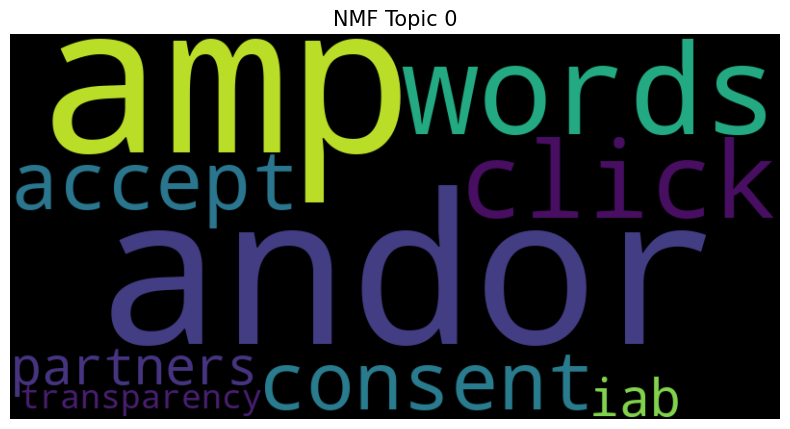

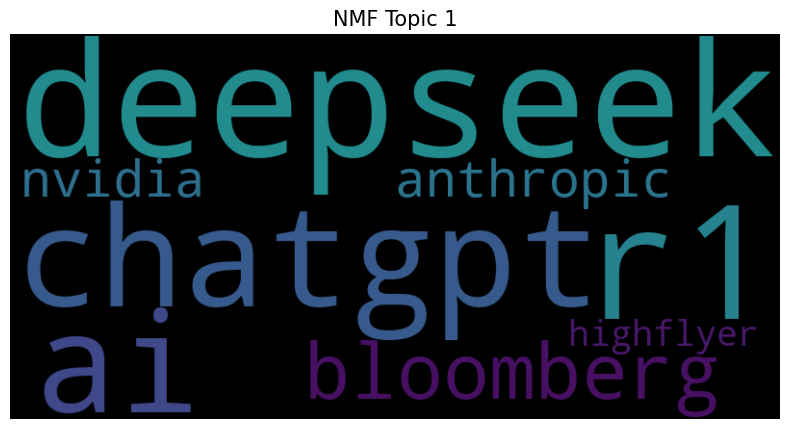

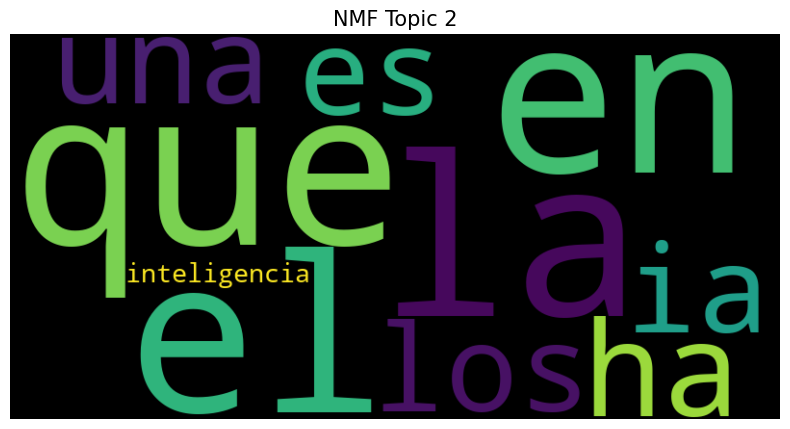

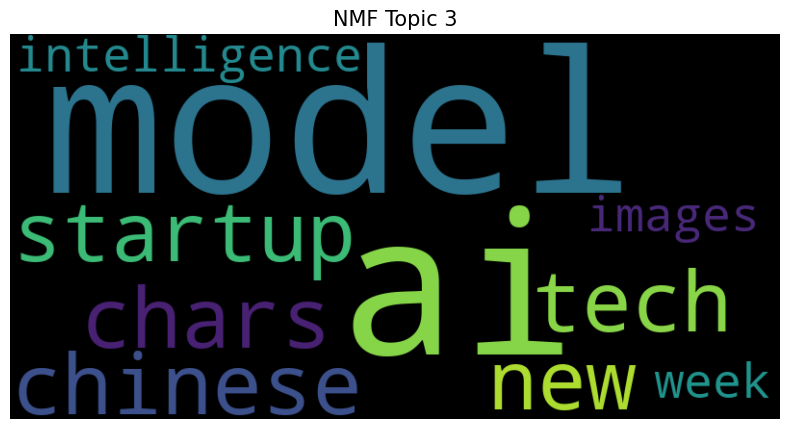

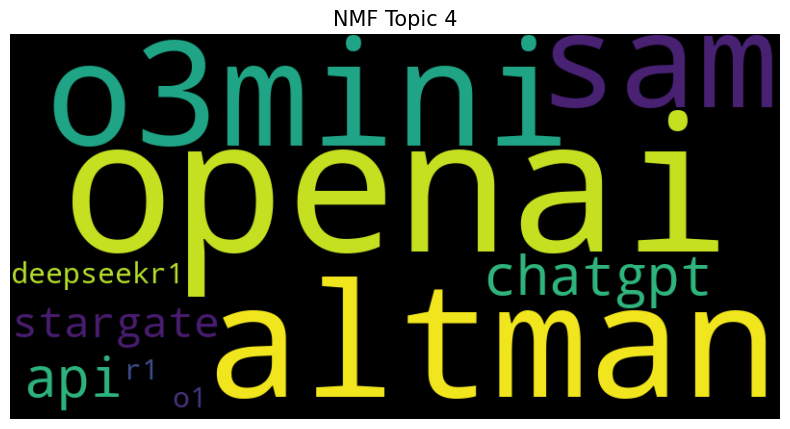

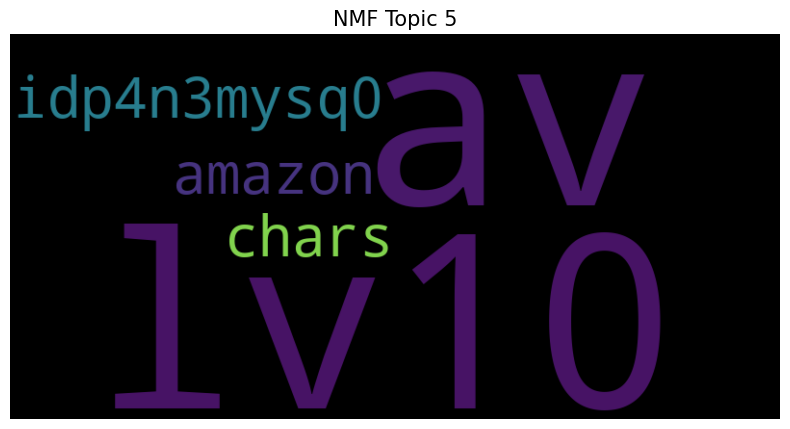

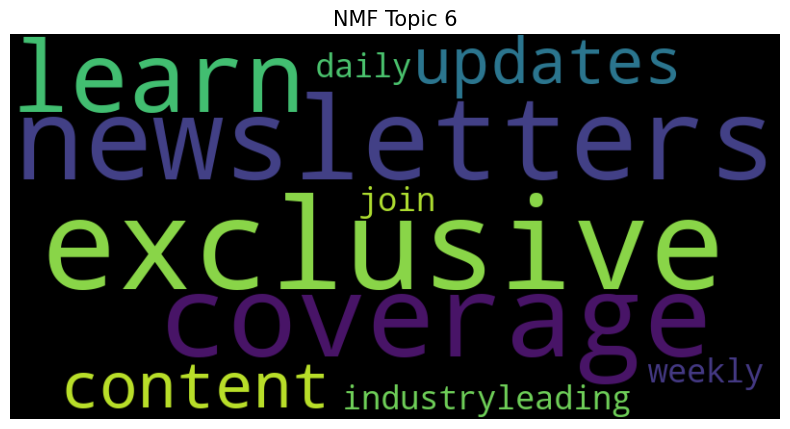

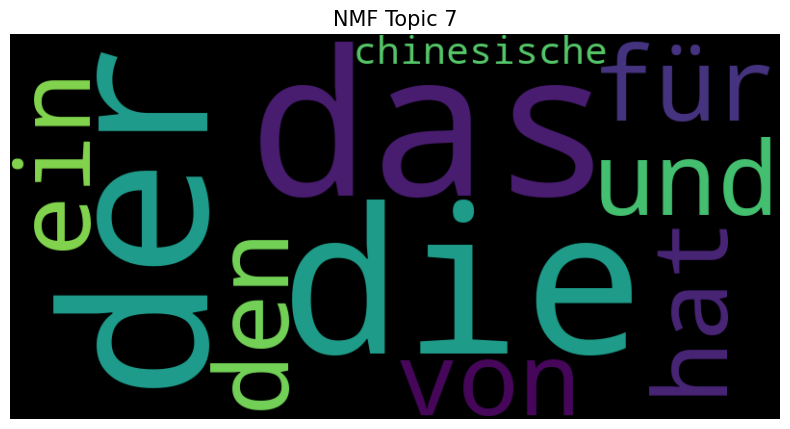

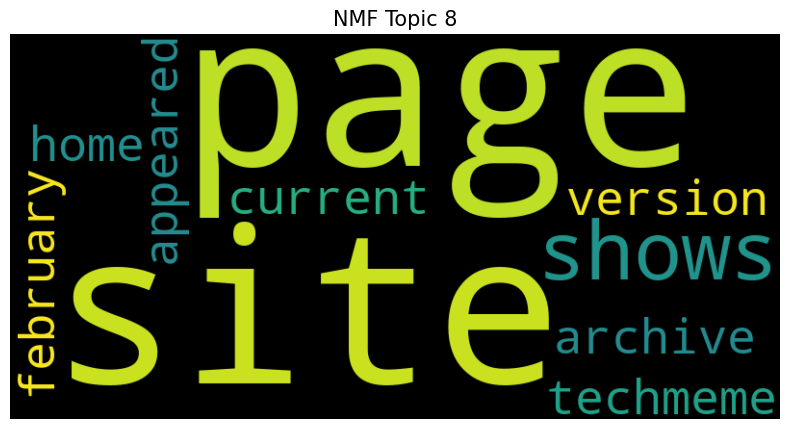

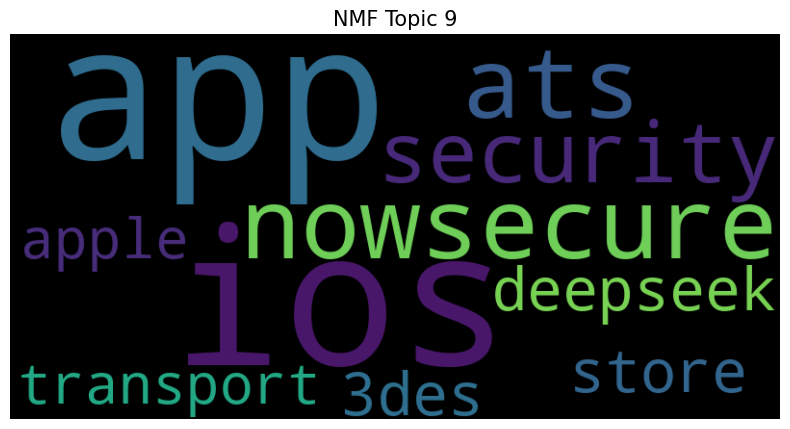

In [32]:
# Define the function to plot the word cloud
def plot_word_cloud(topic_words, title):
    wordcloud = WordCloud(width=800, height=400).generate(" ".join(topic_words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=15)
    plt.show()

# NMF Topics visualization
for topic, words in enumerate(nmf_model.components_):
    topic_words = [tfidf.get_feature_names_out()[i] for i in words.argsort()[:-11:-1]]  # Get top 10 words for each topic
    plot_word_cloud(topic_words, title=f"NMF Topic {topic}")


### LSA Model

In this section, Truncated SVD (LSA) is used to extract topics from text data, map them to article titles, and display the most common ones. Additionally, key terms for each topic are visualized using word clouds.









For topic 7 we have 46 articles.
[('What investors can learn from the DeepSeek tech shock', 1), ('Apple could be looking to bring DeepSeek to Apple Intelligence', 1), ("It's Pebble Time again on the Android Police podcast", 1), ("DeepSeek ended Silicon Valley's AI advantage. That's a good thing", 1), ('OpenAI「o3-mini」投入 ── DeepSeekに対抗', 1)]


For topic 1 we have 292 articles.
[('More Details On Why DeepSeek is a Big Deal', 1), ('SoftBank Is Betting Billions That OpenAI’s Agents Will Automate Work', 1), ('Is DeepSeek China’s Sputnik Moment?', 1), ('Alibaba offers DeepSeek on cloud service after Microsoft, Amazon and Huawei', 1), ('DeepSeek Will Teach You Bomb-Making At Home But Won’t Let You Search Tiananmen Square', 1)]


For topic 2 we have 93 articles.
[('Este es uno de los secretos del éxito de DeepSeek: solo recluta talento chino y paga más de 1,3 millones de dólares', 1), ('Sam Altman admite haberse equivocado con su visión del Open Source. Y todo gracias a DeepSeek', 1), ('Con De

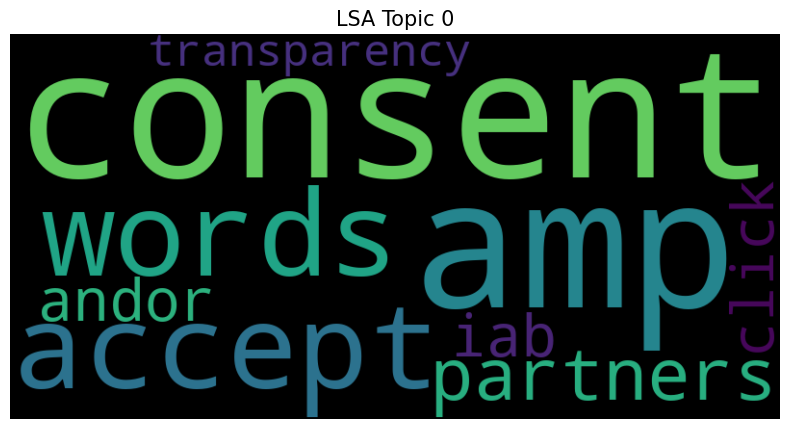

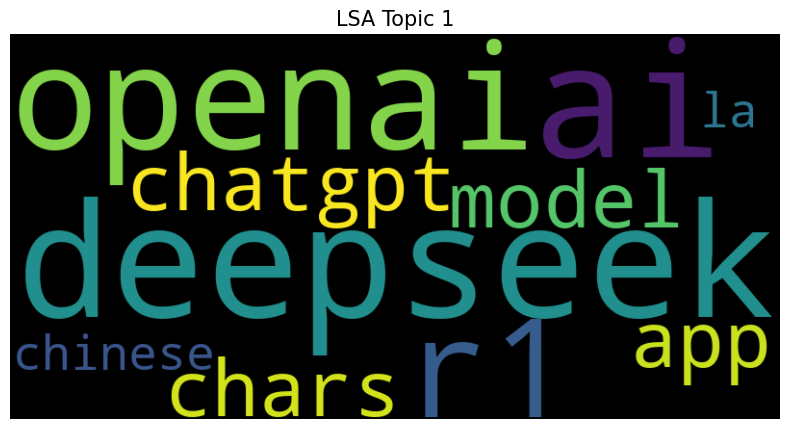

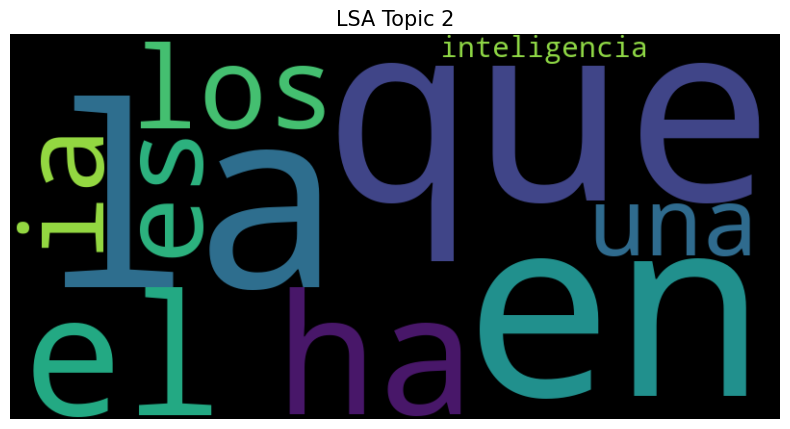

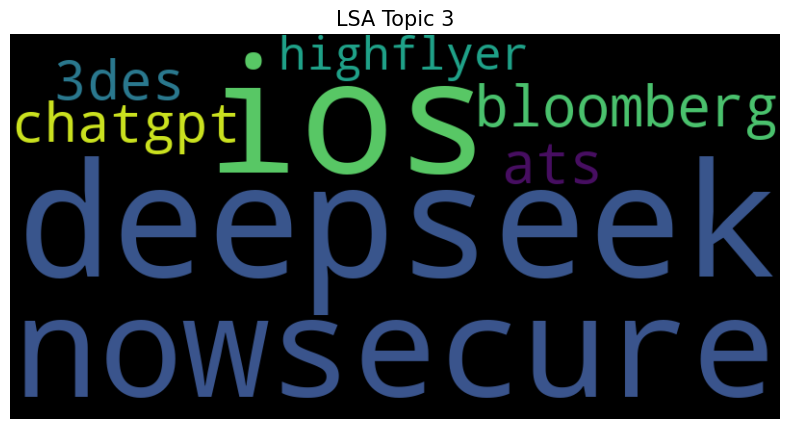

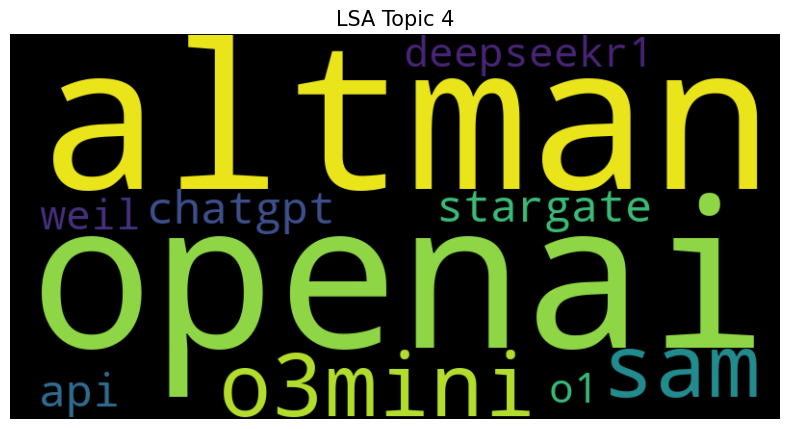

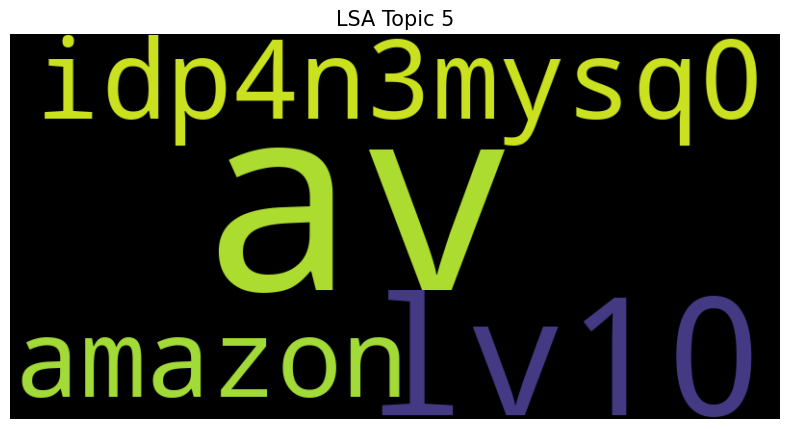

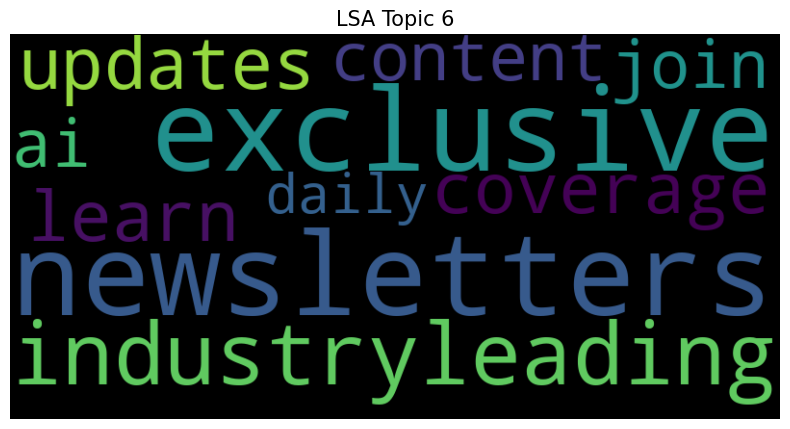

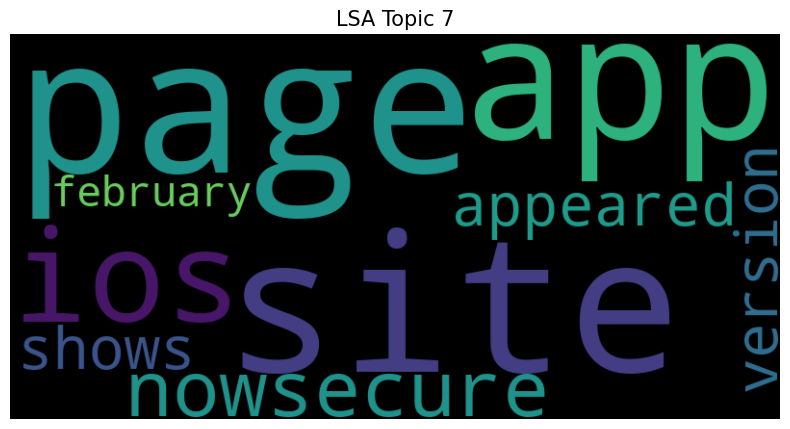

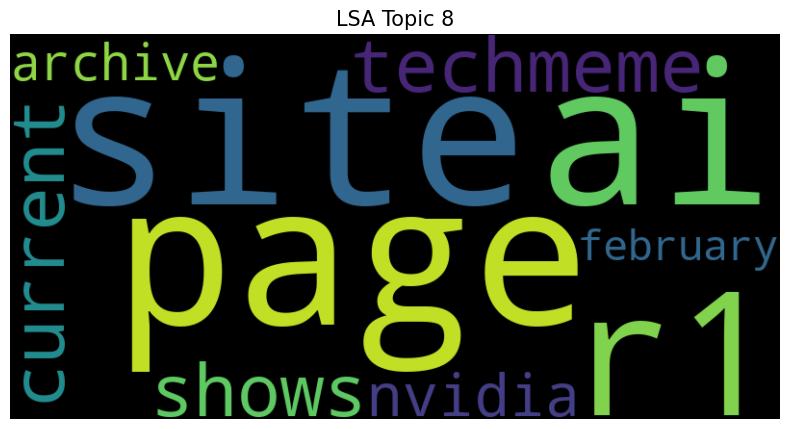

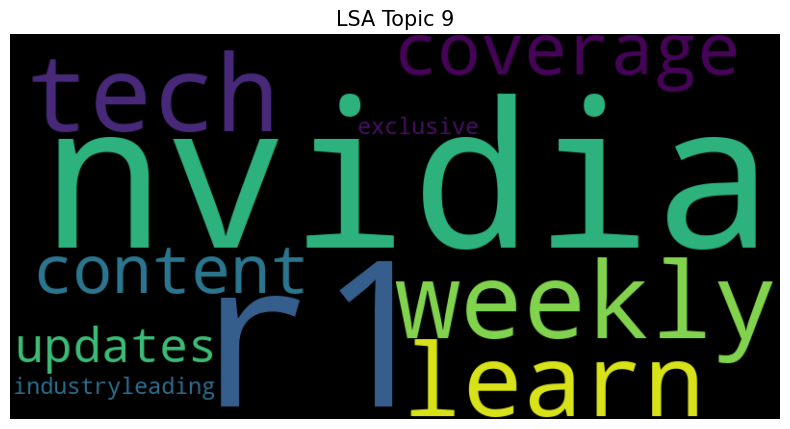

In [84]:
# Fit the TruncatedSVD (LSA) model
svd_text_model = TruncatedSVD(n_components=10, random_state=123)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

# Map topics to article titles or descriptions
lsa_topic_to_category = defaultdict(list)

for idx, row in enumerate(W_svd_text_matrix):
    topic = np.where(row == np.amax(row))[0][0]  
    category = news_df['title'].iloc[idx]  
    lsa_topic_to_category[topic].append(category)

# Display the number of articles for each topic and the most common titles (as a proxy for topics)
for topic, categories in lsa_topic_to_category.items():
    print(f"For topic {topic} we have {len(categories)} articles.")
    print(Counter(categories).most_common(5))  
    print('\n') 

# Create a function to display topics with top words
def display_topics(model, features, no_top_words=10):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1]  # Invert sort order
        print(f"\nTopic {topic:02d}")
        for i in range(0, no_top_words):
            print(f"{features[largest[i]]} ({abs(words[largest[i]] * 100.0 / total):2.2f}%)")

display_topics(svd_text_model, tfidf.get_feature_names_out())

# Function to plot the word cloud for topics
def plot_word_cloud(topic_words, title):
    wordcloud = WordCloud(width=800, height=400).generate(" ".join(topic_words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=15)
    plt.show()

for topic, words in enumerate(svd_text_model.components_):
    topic_words = [tfidf.get_feature_names_out()[i] for i in words.argsort()[:-11:-1]]  # Get top 10 words for each topic
    plot_word_cloud(topic_words, title=f"LSA Topic {topic}")


### LDA Model

In this section, Latent Dirichlet Allocation (LDA) is applied to extract topics from text data using a count-based representation, and the top words for each topic are displayed. Additionally, word clouds are generated to visualize the most important terms in each topic.










Topic 00
 chars (3.30)
 deepseek (2.14)
 store (1.30)
 access (1.24)
 use (1.24)

Topic 01
 chars (3.21)
 ai (2.53)
 deepseek (2.45)
 images (0.81)
 chinese (0.74)

Topic 02
 deepseek (8.96)
 chars (2.80)
 ai (2.04)
 openai (0.76)
 chatgpt (0.57)

Topic 03
 openai (3.89)
 chars (3.17)
 deepseek (2.10)
 ai (1.38)
 altman (1.10)

Topic 04
 deepseek (4.17)
 chars (2.60)
 ai (2.23)
 r1 (1.13)
 model (1.05)

Topic 05
 ai (4.76)
 chars (2.67)
 deepseek (2.48)
 meta (1.27)
 nvidia (1.23)

Topic 06
 deepseek (2.90)
 chars (2.86)
 20250201 (1.76)
 ai (1.23)
 model (0.93)

Topic 07
 chars (2.64)
 deepseek (2.11)
 page (0.82)
 ai (0.73)
 site (0.55)

Topic 08
 la (4.00)
 que (3.08)
 en (3.00)
 chars (2.72)
 el (2.42)

Topic 09
 chars (2.73)
 deepseek (2.02)
 ai (1.57)
 app (0.91)
 tech (0.68)


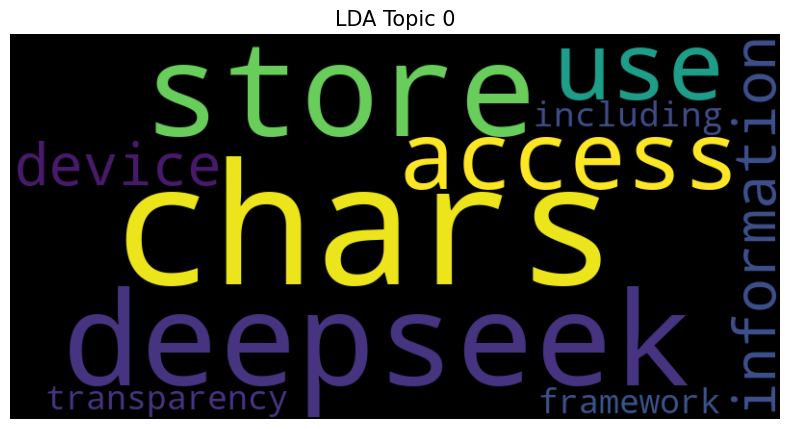

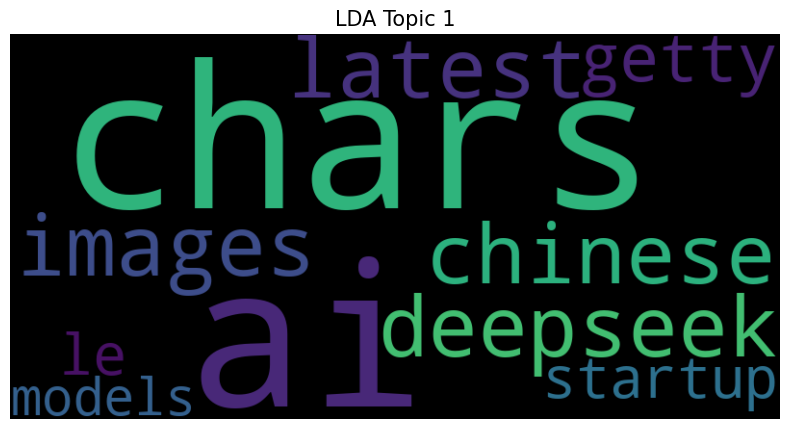

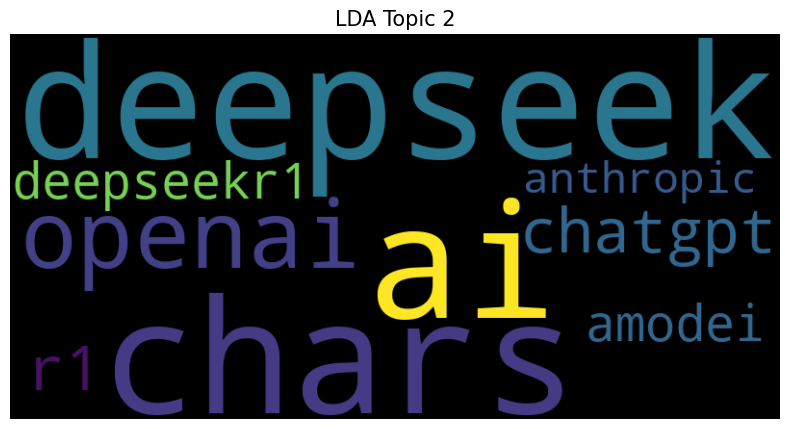

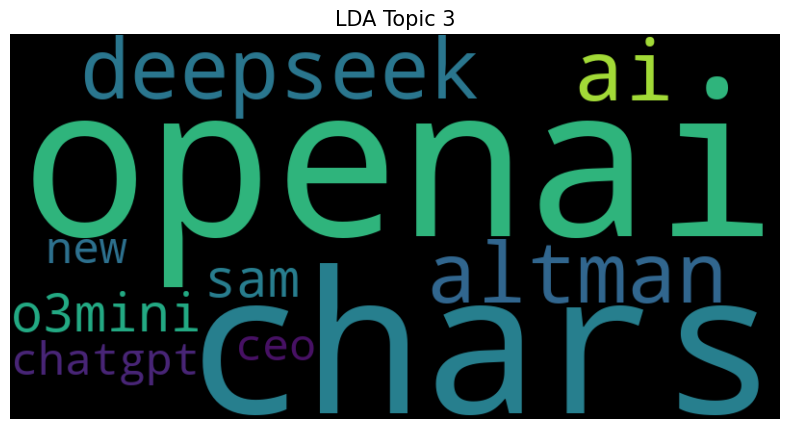

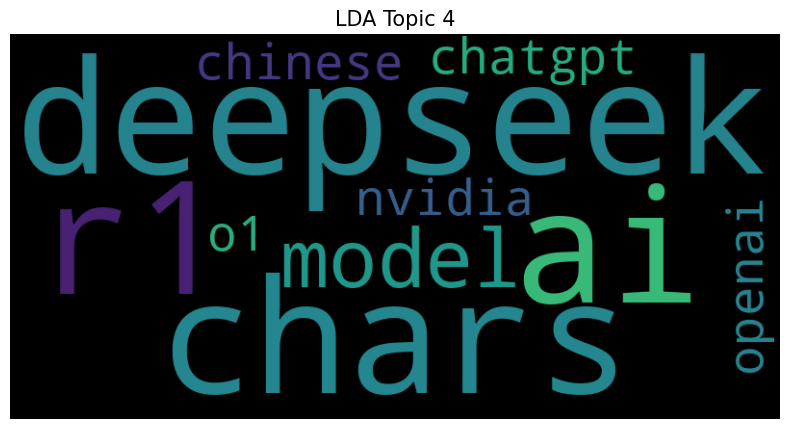

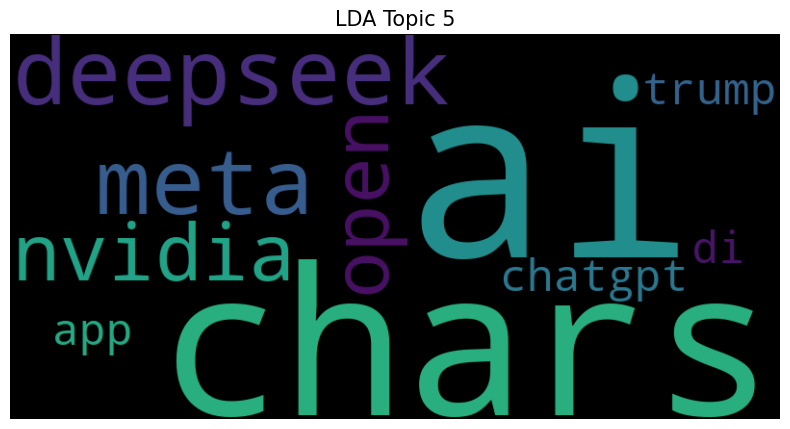

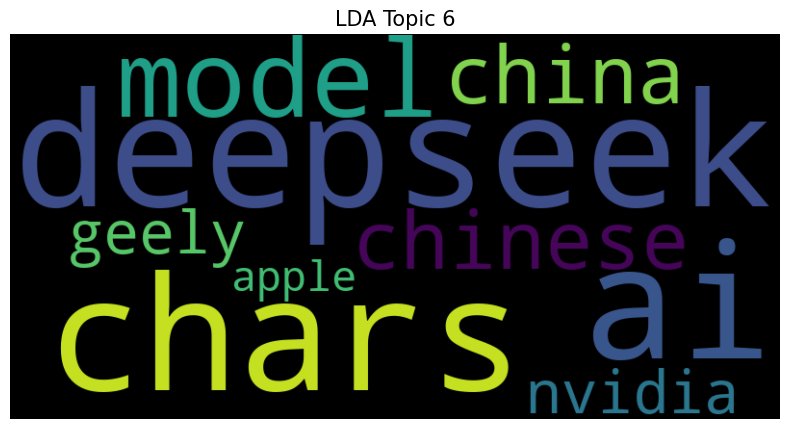

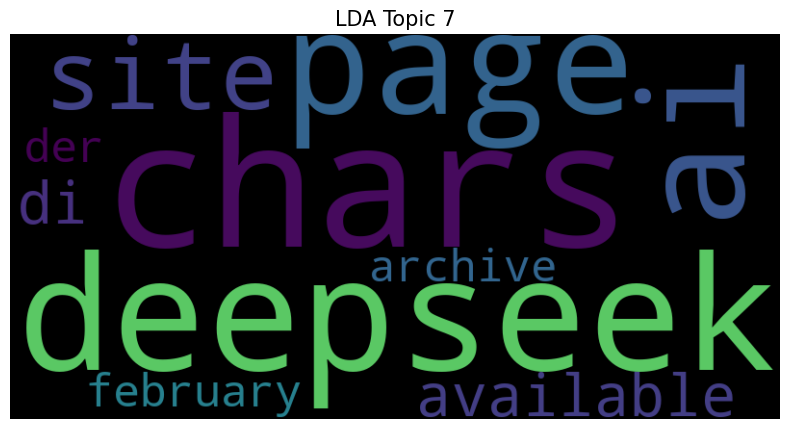

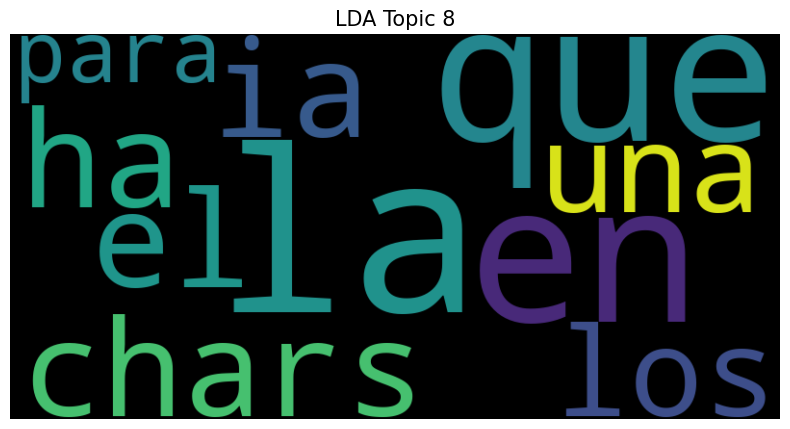

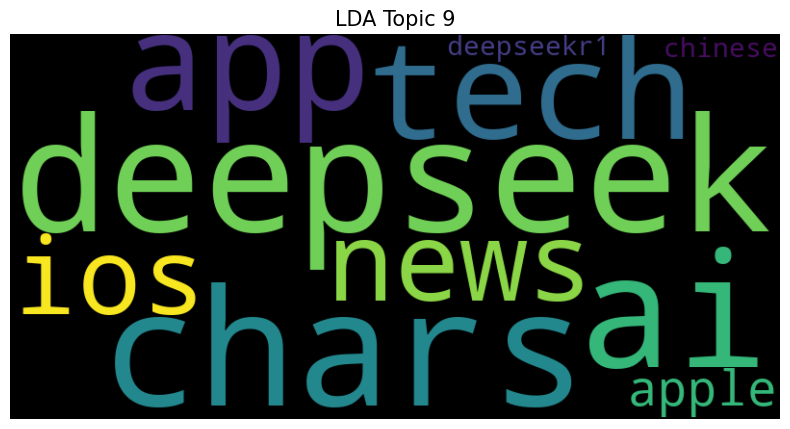

In [82]:
# Vectorizing text using CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
count_text_vectors = count_vectorizer.fit_transform(news_df['Cleaned_Text'])  # Use your dataset

# LDA Topic Modeling with 10 topics
lda_text_model = LatentDirichletAllocation(n_components=10, random_state=314)
W_text_matrix = lda_text_model.fit_transform(count_text_vectors)

# Function to display topics
def display_topics(model, features, no_top_words=5):  
    for topic_idx, topic in enumerate(model.components_):
        total = topic.sum()  # Sum of the topic's word weights
        largest = topic.argsort()[::-1]  # Sort words by importance (highest to lowest)
        print(f"\nTopic {topic_idx:02d}")
        for i in range(no_top_words):
            word = features[largest[i]]
            weight = topic[largest[i]] * 100.0 / total  # Calculate relative importance
            print(f" {word} ({weight:.2f})")

display_topics(lda_text_model, count_vectorizer.get_feature_names_out(), no_top_words=5)

for topic, words in enumerate(lda_text_model.components_):
    topic_words = [tfidf.get_feature_names_out()[i] for i in words.argsort()[:-11:-1]]  # Get top 10 words for each topic
    plot_word_cloud(topic_words, title=f"LDA Topic {topic}")


## Text Classsification

In this section, TF-IDF vectorization is applied to transform text into numerical features, followed by topic modeling using Non-negative Matrix Factorization (NMF) and Latent Semantic Analysis (LSA). Each document is then assigned a dominant topic from both models, allowing for a comparative analysis of topic distributions.
















In [124]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words="english")
tfidf_text_vectors = tfidf_vectorizer.fit_transform(news_df["Cleaned_Text"])  # Use your dataset

# Apply NMF
nmf_model = NMF(n_components=10, random_state=314)
W_nmf_matrix = nmf_model.fit_transform(tfidf_text_vectors)

# Apply LSA (TruncatedSVD)
lsa_model = TruncatedSVD(n_components=10, random_state=314)  # Add LSA Model
W_lsa_matrix = lsa_model.fit_transform(tfidf_text_vectors)  # Compute LSA topic distributions

# Extract Dominant Topics
news_df["LSA_Topic"] = np.argmax(W_lsa_matrix, axis=1)  # Fix: Define W_lsa_matrix
news_df["NMF_Topic"] = np.argmax(W_nmf_matrix, axis=1)

# Validate
print(news_df[["LSA_Topic", "NMF_Topic"]].head())

print(news_df.columns)


   LSA_Topic  NMF_Topic
0          7          6
1          1          1
2          1          3
3          2          2
4          1          3
Index(['source', 'date', 'text', 'title', 'description', 'clean_text',
       'language', 'cleaned_content', 'Cleaned_Text', 'Tokens',
       'Descriptive_Stats', 'sentiment', 'subjectivity', 'LDA_Topic',
       'NMF_Topic', 'LSA_Topic'],
      dtype='object')


/Users/parisakamizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In this section, the dataset is split into training and test sets, with TF-IDF vectorization applied to convert text data into numerical features. The extracted NMF and LSA topic labels are then combined with the TF-IDF features, creating a final feature set for model training and evaluation.









In [126]:
# Define features (X) and labels (y)
X = news_df[['Cleaned_Text', 'NMF_Topic', 'LSA_Topic']]  # Removed LDA & BERTopic since they are not defined
y = news_df['title']  # Target variable


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42  # Removed stratify=y
)


# Vectorize the text data using TF-IDF
tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2), stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train['Cleaned_Text'])
X_test_tfidf = tfidf.transform(X_test['Cleaned_Text'])

# Convert topic labels into numerical format
X_train_topics = np.array(X_train[['NMF_Topic', 'LSA_Topic']])  # Removed LDA & BERTopic
X_test_topics = np.array(X_test[['NMF_Topic', 'LSA_Topic']])

# Combine TF-IDF vectors with topic labels
X_train_final = hstack([X_train_tfidf, X_train_topics])
X_test_final = hstack([X_test_tfidf, X_test_topics])

# Validate the split
print('Size of Training Data:', X_train.shape[0])
print('Size of Test Data:', X_test.shape[0])
print('Shape of Final Training Features:', X_train_final.shape)
print('Shape of Final Test Features:', X_test_final.shape)


Size of Training Data: 456
Size of Test Data: 115
Shape of Final Training Features: (456, 137)
Shape of Final Test Features: (115, 137)


In this section, the text data is split into training and test sets, vectorized using TF-IDF, and then used to train three classification models: Logistic Regression, SVM, and XGBoost. Each model is evaluated on the test set using accuracy and a classification report.









In [128]:
X = news_df['Cleaned_Text']
y = news_df['NMF_Topic']

# Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": SVC(kernel='linear', probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Train & Evaluate Models
for name, model in models.items():
    print(f"\n Training {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f" Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))



 Training Logistic Regression...
 Accuracy: 0.8348
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.78      0.88      0.82        16
           2       0.95      1.00      0.98        20
           3       0.75      0.98      0.85        42
           4       1.00      0.70      0.82        10
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           7       1.00      0.80      0.89         5
           8       1.00      0.25      0.40         4
           9       1.00      0.50      0.67         8

    accuracy                           0.83       115
   macro avg       0.75      0.61      0.64       115
weighted avg       0.82      0.83      0.81       115


 Training SVM...
 Accuracy: 0.8261
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.74      0.88      0.80 

/Users/parisakamizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/parisakamizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/parisakamizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

 Accuracy: 0.8087
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.78      0.88      0.82        16
           2       0.83      1.00      0.91        20
           3       0.81      0.90      0.85        42
           4       0.86      0.60      0.71        10
           5       0.00      0.00      0.00         2
           6       0.50      0.67      0.57         3
           7       1.00      0.60      0.75         5
           8       0.00      0.00      0.00         4
           9       0.83      0.62      0.71         8

    accuracy                           0.81       115
   macro avg       0.66      0.63      0.63       115
weighted avg       0.78      0.81      0.79       115



/Users/parisakamizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/parisakamizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/parisakamizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

The models performed reasonably well, with Logistic Regression achieving the highest accuracy (83.48%), followed closely by SVM (82.61%) and XGBoost (80.87%). However, certain classes, particularly those with fewer samples, had poor precision and recall, leading to undefined metrics in some cases. In the context of a news API, recall is more important than precision because retrieving all relevant articles is crucial, even at the cost of some false positives. To improve performance, techniques such as adjusting decision thresholds or incorporating deep learning approaches like BERT or LSTMs could further optimize results.


Overall, recall was good for some majority classes but poor for minority classes, indicating room for improvement, especially in handling class imbalance. Techniques like class weighting, oversampling, or using a different loss function could help boost recall for underrepresented categories.












**References**

Albrecht, J., Ramachandran, S., & Winkler, C. (2020). Blueprints for text analytics using Python: Machine learning-based solutions for common real-world (NLP) applications [GitHub repository]. O’Reilly. https://github.com/blueprints-for-text-analytics-python/blueprints-text/tree/master

OpenAI. (2025). ChatGPT (Feb 13 version) [Large language model]. https://openai.com